In [1]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d digvijayyadav/frenchenglish

Dataset URL: https://www.kaggle.com/datasets/digvijayyadav/frenchenglish
License(s): copyright-authors
 87% 5.00M/5.77M [00:00<00:00, 42.3MB/s]
100% 5.77M/5.77M [00:00<00:00, 47.7MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/frenchenglish.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
data_path = '/content/fra.txt'

In [5]:
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000

In [6]:
english_sentences = []
french_sentences = []

english_chracters = set()
french_characters = set()

with open(data_path,'r',encoding='utf-8') as f:
  lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
  english_sentence, french_sentence,_ = line.split('\t')
  french_sentence = '<start> ' + french_sentence + " <end>"
  english_sentences.append(english_sentence)
  french_sentences.append(french_sentence)

In [7]:
import pandas as pd
df1 = pd.DataFrame(english_sentences, columns=['English'])
df2 = pd.DataFrame(french_sentences, columns=['French'])
df = pd.concat([df1, df2], axis=1)
df.head(10)

,English,French
0,Go.,<start> Va ! <end>
1,Hi.,<start> Salut ! <end>
2,Hi.,<start> Salut. <end>
3,Run!,<start> Cours ! <end>
4,Run!,<start> Courez ! <end>
5,Who?,<start> Qui ? <end>
6,Wow!,<start> Ça alors ! <end>
7,Fire!,<start> Au feu ! <end>
8,Help!,<start> À l'aide ! <end>
9,Jump.,<start> Saute. <end>


In [8]:
df.shape

(10000, 2)

In [9]:
## Splitting dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['English'],df['French'], test_size=0.1, random_state=0)

In [56]:
df[df['French'] == '<start> tom <end>']

,English,French


In [10]:
from math import e
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

e_tokenizer = Tokenizer()
e_tokenizer.fit_on_texts(list(X_train))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in e_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [11]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
eng_max_features = total_count - count
print('Text Vocab: ', eng_max_features)

% of rare words in vocabulary:  62.31468197034912
Total Coverage of rare words:  8.313942023269572
Text Vocab:  788


In [12]:
f_tokenizer = Tokenizer()
f_tokenizer.fit_on_texts(list(y_train))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in f_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [13]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
fra_max_features = total_count-count
print('Summary Vocab: ', fra_max_features)

% of rare words in vocabulary:  86.44147314098053
Total Coverage of rare words:  13.109724496776467
Summary Vocab:  578


In [14]:
X_train

,English
1554,Let him go!
2087,He loves us.
5470,I had to stop.
2363,I was alone.
7570,Happy New Year!
...,...
9225,This annoys me.
4859,Are they dead?
3264,Be objective.
9845,You're in luck.


In [15]:
#finding max_len for padding
max_eng_seq_len = max(len(seq) for seq in X_train)
max_fra_seq_len = max(len(seq) for seq in y_train)

In [16]:
max_fra_seq_len

71

In [17]:
##Making Input sequences and applying fit_on_texts() only on X_train,y_train not on X_test and y_test
X_val = X_test
t_tokenizer = Tokenizer(num_words=eng_max_features)
t_tokenizer.fit_on_texts(list(X_train))
X_train = t_tokenizer.texts_to_sequences(X_train)
X_val = t_tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(X_train, maxlen=max_eng_seq_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_eng_seq_len, padding='post')

In [18]:
y_val = y_test
s_tokenizer = Tokenizer(num_words=fra_max_features)
s_tokenizer.fit_on_texts(list(y_train))
y_train = s_tokenizer.texts_to_sequences(y_train)
y_val = s_tokenizer.texts_to_sequences(y_val)

y_train = pad_sequences(y_train, maxlen=max_fra_seq_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_fra_seq_len, padding='post')

In [19]:
print("Training Sequence", X_train.shape)
print('Target Values Shape', y_train.shape)
print('Test Sequence', X_val.shape)
print('Target Test Shape', y_val.shape)

Training Sequence (9000, 16)
Target Values Shape (9000, 71)
Test Sequence (1000, 16)
Target Test Shape (1000, 71)


##Model Architecture

In [20]:
## Encoder building
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
embed_dim = 256
units = 512
enc_input =Input(shape=(max_eng_seq_len, ))
enc_embed = Embedding(eng_max_features, embed_dim, input_length = max_eng_seq_len)(enc_input)
enc_lstm = Bidirectional(LSTM(units, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
## Decoder Building
from tensorflow.keras.layers import Attention
dec_input = Input(shape=(None, ))
dec_embed = Embedding(fra_max_features, embed_dim)(dec_input)
dec_lstm = LSTM(units*2, return_sequences=True, return_state=True, dropout=0.3,recurrent_dropout=0.2)
dec_outputs,_,_ = dec_lstm(dec_embed, initial_state=[enc_h,enc_c])

# Define the Attention layer
attention_layer = Attention(name='attention_layer')
attention_result = attention_layer([dec_outputs, enc_output])

# Concatenate attention result with LSTM output
dec_output_combined = Concatenate(axis=-1)([attention_result, dec_outputs])

# Pass combined output through a dense layer
dec_output_final = TimeDistributed(Dense(fra_max_features, activation='softmax'))(dec_output_combined)

# dec_dense = TimeDistributed(Dense(fra_max_features, activation='softmax'))
# dec_output = dec_dense(dec_outputs)

In [22]:
#Model Building
model = Model([enc_input, dec_input], dec_output_final)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 16, 256)        │        201,728 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 1024), (None,  │      3,149,824 │ embedding[0][0]        │
│ (Bidirectional)           │ 512), (None, 512),     │                │                        │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │        147,968 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_h (Concatenate)       │ (None, 1024)           │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_c (Concatenate)       │ (None, 1024)           │              0 │ bidirectional[0][2],   │
│                           │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 1024),   │      5,246,976 │ embedding_1[0][0],     │
│                           │ (None, 1024), (None,   │                │ enc_h[0][0],           │
│                           │ 1024)]                 │                │ enc_c[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 578)      │        592,450 │ lstm_1[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,338,946 (35.63 MB)

 Trainable params: 9,338,946 (35.63 MB)

 Non-trainable params: 0 (0.00 B)

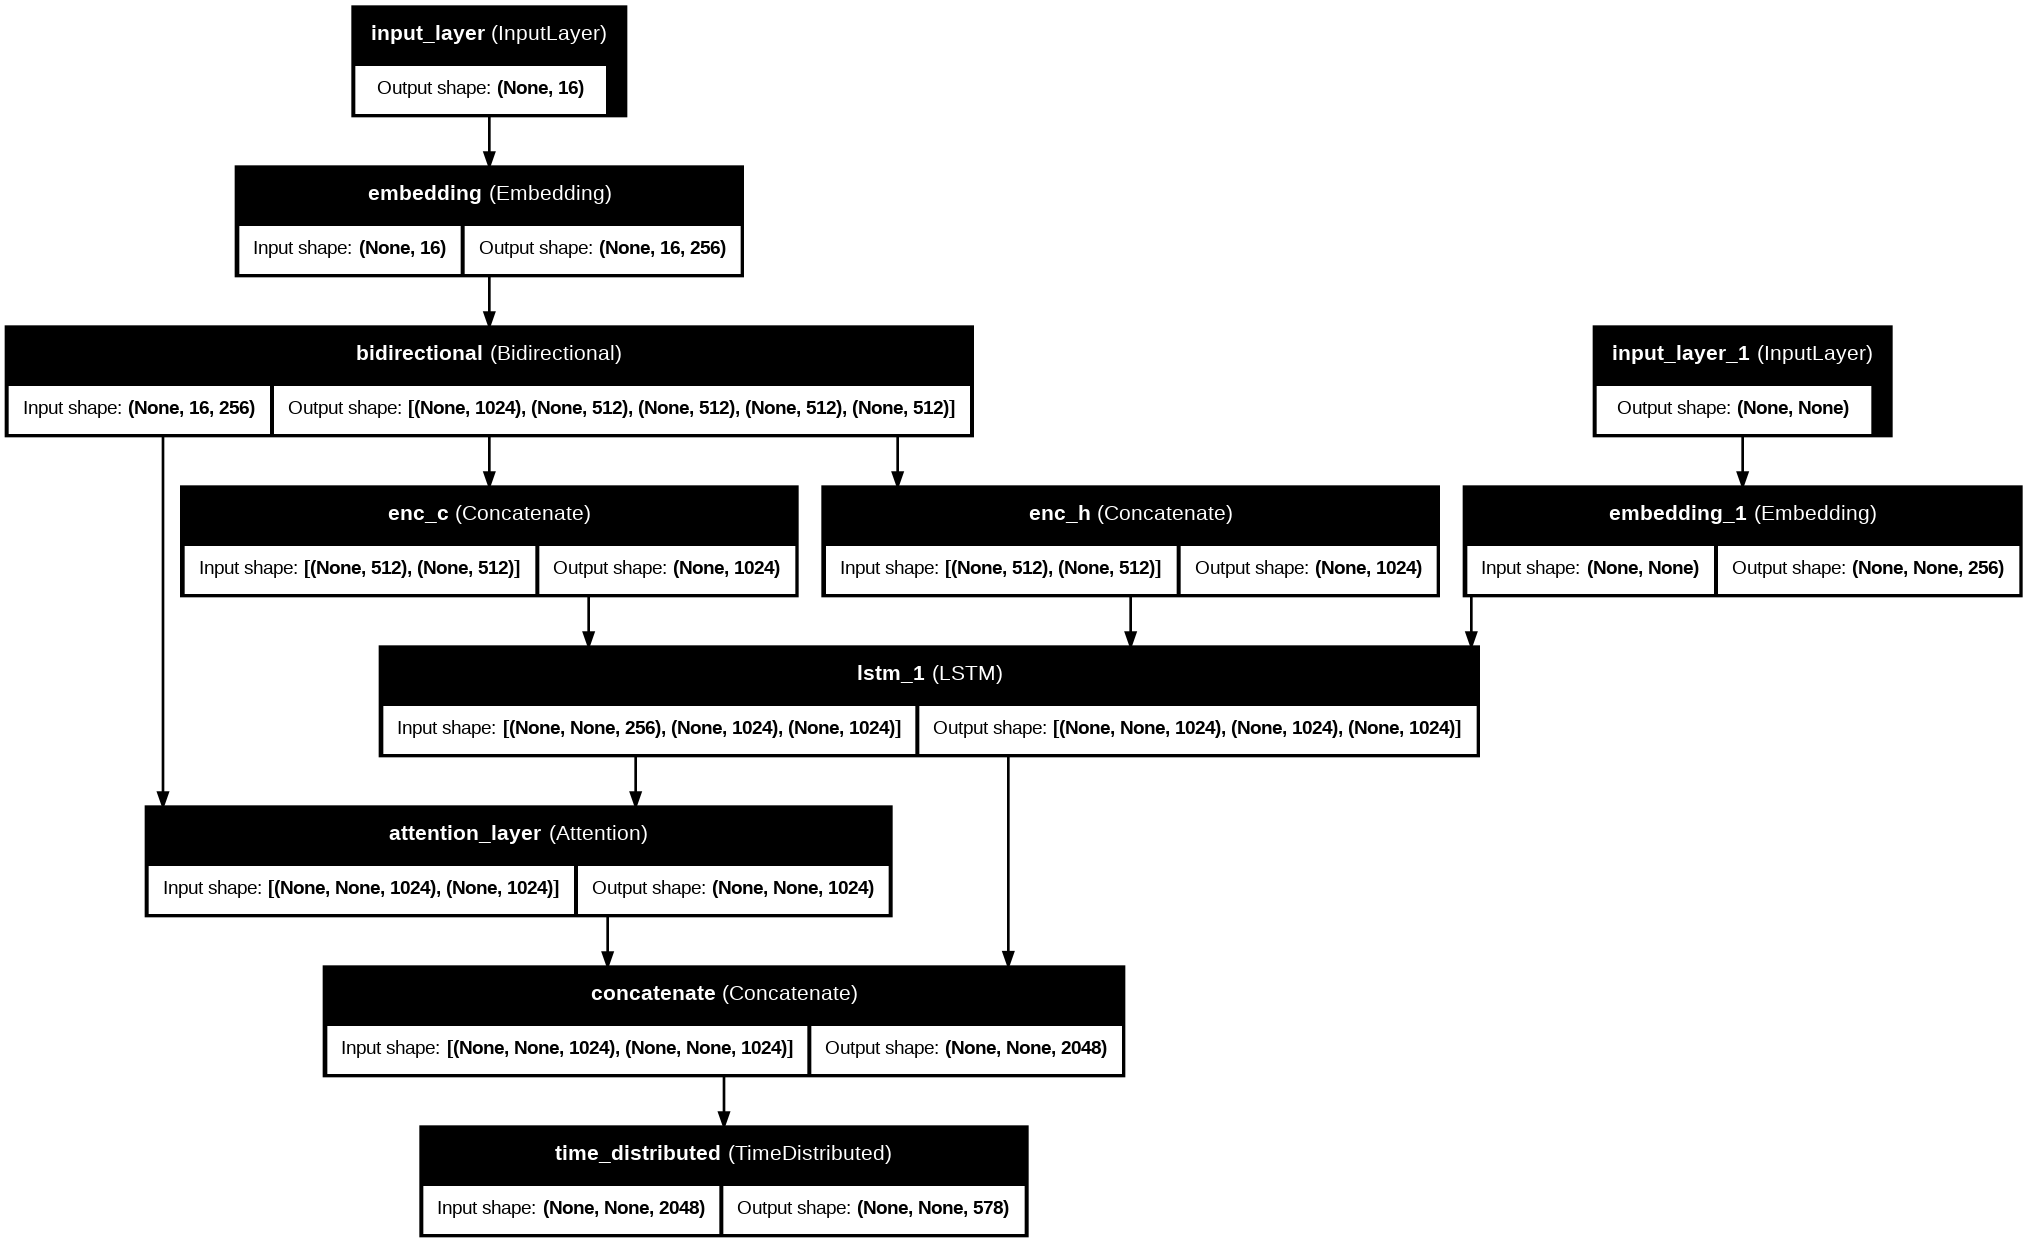

In [23]:
plot_model(model,
           to_file='/content/eng_fra_encoder_decoder.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir="TB",
           expand_nested='False',
           dpi=96)

In [24]:
#model compile and Training

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model.fit([X_train, y_train[:,:-1]],
          y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
          epochs=20,
          callbacks=[early_stop],
          batch_size=64,
          verbose=1,
          validation_data = ([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
          )

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.9152 - loss: 0.6735 - val_accuracy: 0.9626 - val_loss: 0.2162
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.9643 - loss: 0.2132 - val_accuracy: 0.9645 - val_loss: 0.2030
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.9646 - loss: 0.2048 - val_accuracy: 0.9645 - val_loss: 0.2002
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.9646 - loss: 0.2017 - val_accuracy: 0.9645 - val_loss: 0.1986
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9644 - loss: 0.2015 - val_accuracy: 0.9645 - val_loss: 0.1979
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.9647 - loss: 0.1992 - val_accuracy: 0.9648 - val_loss: 0.1979
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.9650 - loss: 0.1962 - val_accuracy: 0.9645 - val_loss: 0.1940
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9654 - loss: 0

In [25]:
enc_model = Model(inputs=enc_input, outputs=[enc_h,enc_c])

dec_init_state_h = Input(shape=(units*2, ))
dec_init_state_c = Input(shape=(units*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h,dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+ [dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h,dec_c])

In [26]:
import pickle

#save encoder model
enc_model.save('/content/text_summ_encoder_model.h5')

#save Decoder model
dec_model.save('/content/text_summ_decoder_model.h5')

#Save tokenizer

with open('/content/s_tokenizer.pkl', 'wb') as f:
  pickle.dump(s_tokenizer, f)

In [57]:
# text = "who?"

# get_sum_for_text = generate2_summary2(text)
# print(get_sum_for_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
tom


In [64]:
import numpy as np
import tensorflow as tf
import pickle

# Load the tokenizer
with open('/content/s_tokenizer.pkl', 'rb') as f:
    s_tokenizer = pickle.load(f)

# Load the encoder and decoder models
enc_model = tf.keras.models.load_model('/content/text_summ_encoder_model.h5')
dec_model = tf.keras.models.load_model('/content/text_summ_decoder_model.h5')

def generate_french_translation(input_text, max_eng_seq_len, max_fra_seq_len):
    # Preprocess the input text
    input_seq = t_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_eng_seq_len, padding='post')

    # Use the encoder model to get the states
    enc_h, enc_c = enc_model.predict(input_seq)

    # Initialize the target sequence with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = s_tokenizer.word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next word
        dec_outputs, dec_h, dec_c = dec_model.predict([target_seq] + [enc_h, enc_c])

        # Get the token index with the highest probability
        token_idx = np.argmax(dec_outputs[0, -1, :])

        # Convert the token index to the word
        sampled_word = s_tokenizer.index_word.get(token_idx, '<UNK>')

        # If we get the end token, stop the generation
        if sampled_word == 'end' or len(decoded_sentence.split()) > max_fra_seq_len:
            stop_condition = True
        else:
            # Append the word to the decoded sentence
            decoded_sentence += ' ' + sampled_word

            # Update the target sequence
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = token_idx

            # Update the states
            enc_h, enc_c = dec_h, dec_c

    return decoded_sentence.strip()

# Example usage:
input_text = "I love learning new languages"
translated_text = generate_french_translation(input_text, max_eng_seq_len, max_fra_seq_len)
print("Translated text:", translated_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Translated text: je me pas
